---
# Rainfall Prediction Using Indigenous Knowledge

## 1. Introduction

Accurate rainfall prediction is essential for agriculture, disaster preparedness, and water resource management. In many rural and indigenous communities, traditional knowledge—based on environmental cues such as animal behavior, wind direction, cloud formation, and plant responses—has long been used to anticipate rainfall patterns.

This project seeks to bridge **indigenous forecasting wisdom** with **modern machine learning techniques** to predict rainfall within the next **12 to 24 hours**.

The goal is not only to improve rainfall prediction accuracy but also to **validate and preserve indigenous knowledge** by integrating it into data-driven climate models. This approach fosters inclusivity, enhances local forecasting capabilities, and contributes to sustainable adaptation strategies in regions where access to advanced weather systems may be limited.

---

---
## 2. Environment Reproduction

To ensure the **reproducibility** of results, this section outlines the setup required to recreate the project environment. Recreating the same environment guarantees that all dependencies, package versions, and configurations remain consistent across different systems.

The following steps and requirement files (e.g., `requirements.txt`) can be used to replicate the environment used in this notebook.

---

In [1]:
# Path to the requirements.txt file
REQUIREMENT_PATH = "/kaggle/input/environment-file/requirements.txt"

In [2]:
# Code to install all dependencies
!pip install -r {REQUIREMENT_PATH}

In [3]:
# Core utilities
import os               # For interacting with the operating system (paths, directories)
import glob             # For pattern-based file and folder searching
import time             # For tracking and measuring execution time

# Numerical, visualization, and data processing
import numpy as np      # For numerical computations and array operations
import pandas as pd     # For handling and analyzing tabular data (DataFrames)
import matplotlib.pyplot as plt # For visualization

# Machine learning and evaluation
import xgboost as xgb   # For gradient boosting models (XGBoost implementation)
from xgboost import XGBClassifier  # Main classifier used for rainfall prediction
from sklearn.model_selection import StratifiedKFold  # For stratified cross-validation to handle class imbalance
from sklearn.metrics import f1_score                 # For evaluating model performance (harmonic mean of precision & recall)
from sklearn.preprocessing import OneHotEncoder      # For encoding categorical variables into numeric form

# Model explainability
import shap             # For model interpretability using SHAP values

# Model conversion and interoperability
import onnx             # Open Neural Network Exchange format (for model portability)
import onnxmltools       # For converting models (e.g., XGBoost) to ONNX format
from onnxmltools.convert.common.data_types import FloatTensorType  # For defining ONNX input tensor types
import onnxruntime as rt # For running ONNX models efficiently during inference

In [4]:
# Display up to 500 columns when printing DataFrames (useful for wide datasets)
pd.set_option('display.max_columns', 500)

# Initialize SHAP's JavaScript visualization environment for interactive plots
shap.initjs()

In [5]:
# Number of folds to use for stratified cross-validation
FOLDS = 20  

# File path to the test dataset (used for final inference)
TEST_PATH = "/kaggle/input/ghanas-indigenous-challenge-dataset/test.csv"  

# File path to the training dataset (used for model training and validation)
TRAIN_PATH = "/kaggle/input/ghanas-indigenous-challenge-dataset/train.csv"  

# Random seed for reproducibility (ensures consistent fold splits and model behavior)
RANDOM_STATE = 44  

---
## 3. ETL Process

In this section, we extract and transform the raw data to prepare it for model training and inference.
The workflow involves several key preprocessing steps designed to clean, structure, and encode the dataset effectively for XGBoost and ONNX compatibility.

**Process Summary:**

1. **Read CSV files** – Load the training and test datasets using `pandas`.
2. **Extract time-based features** – Derive temporal variables such as `month`, `day`, `hour`, `prediction date`, and `day_of_week` from the `prediction_time` column.
3. **Drop unnecessary columns** – Remove non-informative or redundant fields (e.g., `prediction_time`, `indicator_description`, `time_observed`, and `ID`).
4. **Factorize categorical columns** – Convert text-based categorical variables (e.g., `community`, `indicator`) into integer codes for consistency.
5. **Apply One-Hot Encoding** – Encode all categorical variables using `OneHotEncoder` to improve interpretability and avoid target leakage.
6. **Rename columns** – Format all column names to `f%d` style for compatibility with the ONNX export process.

---

In [6]:
def read_csv_add_datetime_features(path: str, is_train: bool = True) -> pd.DataFrame:
    """
    Reads a CSV file from the given path and extracts useful datetime features 
    from the 'prediction_time' column. The function also prepares the dataset
    for model training or inference, depending on the `is_train` flag.

    ------------------------------------------------------------
    FUNCTION OVERVIEW
    ------------------------------------------------------------
    - Converts prediction_time to datetime format.
    - Creates new columns:
        * month     : Month of the prediction (float16)
        * day       : Day of the month (float16)
        * hour      : Hour of the day (float16)
        * pred_date : Date in string format (YYYY-MM-DD)
        * dow       : Day of the week (float16, Monday=0, Sunday=6)
    - Drops non-feature columns depending on whether the data is used for
      training or inference.
    - If is_train=True, maps rainfall intensity labels from text to integers:
        NORAIN → 0
        SMALLRAIN → 1
        MEDIUMRAIN → 2
        HEAVYRAIN → 3

    ------------------------------------------------------------
    PARAMETERS
    ------------------------------------------------------------
    Args:
        path (str): 
            Path to the CSV file containing the data.
        is_train (bool, default=True): 
            Indicates whether the dataset is for training (includes Target column)
            or for inference (test data without Target).

    ------------------------------------------------------------
    RAISES
    ------------------------------------------------------------
        ValueError: 
            If the prediction_time column is missing from the dataset.

    ------------------------------------------------------------
    RETURNS
    ------------------------------------------------------------
        Tuple[pd.DataFrame, Optional[pd.Series]]:
            - df : pd.DataFrame
                The processed DataFrame with datetime-derived columns.
            - y : pd.Series or None
                Encoded target labels if is_train=True; otherwise None.
    """


    # Read the CSV file
    df = pd.read_csv(path)

    # Ensure required datetime column exists
    if "prediction_time" not in df.columns:
        raise ValueError("Error: The column 'prediction_time' is missing from the dataset.")

    # Convert to datetime
    df["prediction_time"] = pd.to_datetime(df["prediction_time"])

    # Extract datetime-based features
    df["month"] = df["prediction_time"].dt.month.astype("float16")
    df["day"] = df["prediction_time"].dt.day.astype("float16")
    df["hour"] = df["prediction_time"].dt.hour.astype("float16")
    df["pred_date"] = df["prediction_time"].dt.date.astype("str")
    df["dow"] = df["prediction_time"].dt.dayofweek.astype("float16")

    # Handle train/test-specific preprocessing
    if is_train:
        # Encode target variable
        y = df["Target"].map({
            "NORAIN": 0,
            "SMALLRAIN": 1,
            "MEDIUMRAIN": 2,
            "HEAVYRAIN": 3
        }).astype("int16")

        # Drop columns not used for model training
        df = df.drop(columns=[
            "prediction_time", "indicator_description", 
            "time_observed", "ID", "Target"
        ], 
                     errors='ignore')
    else:
        y = df["ID"]

        # Drop columns not used for inference
        df = df.drop(columns=[
            "prediction_time", "indicator_description", 
            "time_observed", "ID"
        ], 
                     errors='ignore')

    return df, y


In [7]:
%%time
train, y = read_csv_add_datetime_features(TRAIN_PATH)
test, test_id = read_csv_add_datetime_features(TEST_PATH, False)

CPU times: user 72.9 ms, sys: 20.2 ms, total: 93.1 ms
Wall time: 103 ms


In [8]:
# Columns to be one-hot encoded
one_hot_cols = ["community", "district", "indicator", "pred_date"]

# Other continuous or numeric columns used as-is
other_cols = ["user_id", "predicted_intensity", "confidence",
              "forecast_length", "month", "day", "hour", "dow"]

In [9]:
def preprocess_and_factorize(train_df: pd.DataFrame, test_df: pd.DataFrame, categorical_cols: list):
    """
    Cleans, optimizes, and factorizes categorical columns in both training and testing datasets.

    ------------------------------------------------------------
    FUNCTION OVERVIEW
    ------------------------------------------------------------
    This function performs consistent preprocessing between training and testing data by:
    1️⃣ Filling missing values and cleaning text fields.
    2️⃣ Downcasting numerical types for memory efficiency.
    3️⃣ Encoding categorical columns using integer factorization.
       - Test data is encoded using the same mapping as training data.
       - Unseen categories in test data are automatically assigned new integer codes.

    ------------------------------------------------------------
    PARAMETERS
    ------------------------------------------------------------
    Args:
        train_df (pd.DataFrame): 
            The training dataset to be processed and encoded.
        test_df (pd.DataFrame): 
            The testing dataset to be processed and encoded.
        categorical_cols (list): 
            List of categorical column names to factorize.

    ------------------------------------------------------------
    RETURNS
    ------------------------------------------------------------
        Tuple[pd.DataFrame, pd.DataFrame, dict]:
            - train_encoded : pd.DataFrame  
              The cleaned and encoded training dataset.
            - test_encoded : pd.DataFrame  
              The cleaned and encoded testing dataset.
            - encoders : dict  
              Dictionary mapping each categorical column to its list of unique categories 
              (useful for inverse transformations or interpretation).

    ------------------------------------------------------------
    PROCESS STEPS
    ------------------------------------------------------------
    1. Cleaning and Optimization
       - Fills missing values in all columns with the string "missing".
       - Strips whitespace and lowercases text for categorical consistency.
       - Downcasts:
         * int64 → int16  
         * float64 → float16  

    2. Factorization
       - Uses pd.factorize() to convert each categorical column into integer codes.
       - Creates a shared encoding dictionary (`encoders`) for reproducibility.
       - Handles unseen categories in test data by assigning unique new codes 
         beyond the range of training encodings.

    """

    # --- Copy to avoid modifying originals ---
    train_encoded, test_encoded = train_df.copy(), test_df.copy()
    encoders = {}

    # ------------------------------------------------------------
    # Step 1: Clean and optimize column types
    # ------------------------------------------------------------
    for df in [train_encoded, test_encoded]:
        for c in df.columns:
            # Fill missing values with a placeholder
            if df[c].isnull().any():
                df[c] = df[c].fillna("missing")

            # Clean text columns (standardize format)
            if df[c].dtype == "object":
                if c in ["community", "indicator"]:
                    df[c] = (
                        df[c]
                        .str.lower()
                        .str.strip()
                        .str.replace(r"\s+", " ", regex=True)
                    )
            # Downcast numerical types to save memory
            elif df[c].dtype == "int64":
                df[c] = df[c].astype("int16")
            elif df[c].dtype == "float64":
                df[c] = df[c].astype("float16")
                
    # ------------------------------------------------------------
    # Step 2: Factorize categorical columns
    # ------------------------------------------------------------
    for col in categorical_cols:
        # Fit encoder on training data
        train_encoded[col], uniques = pd.factorize(
            train_encoded[col]
        )
        encoders[col] = uniques

        # Map test data to training encodings
        test_vals = test_encoded[col]
        mapping = {v: i for i, v in enumerate(uniques)}
        unseen_start = len(uniques)

        # Encode known categories
        test_encoded[col] = test_vals.map(mapping)

        # Identify and encode unseen categories
        unseen_mask = test_encoded[col].isna()
        if unseen_mask.any():
            unseen_values = test_vals[unseen_mask].unique()
            unseen_map = {v: unseen_start + i for i, v in enumerate(unseen_values)}
            test_encoded[col] = test_encoded[col].fillna(test_vals.map(unseen_map))

        # Ensure final encoded dtype is compact
        test_encoded[col] = test_encoded[col].astype("int16")

    return train_encoded, test_encoded, encoders


In [10]:
%%time
# Categorical columns to label encode
categorical_cols = ["community", "indicator"]

# Apply preprocessing and factorization
train, test, encoders = preprocess_and_factorize(train, test, categorical_cols)

CPU times: user 53.4 ms, sys: 61 µs, total: 53.5 ms
Wall time: 52.6 ms


In [11]:
%%time
# Initialize OneHotEncoder
# - sparse_output=False → returns a dense NumPy array
# - handle_unknown="ignore" → avoids errors for unseen categories in test data
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# ------------------------------------------------------------
# Apply encoding on TRAINING data
# ------------------------------------------------------------
train_ohe = ohe.fit_transform(train[one_hot_cols])           # Fit encoder and transform categorical features
columns_ohe = ohe.get_feature_names_out(one_hot_cols)        # Retrieve encoded column names with prefixes
train_ohe = pd.DataFrame(train_ohe, columns=columns_ohe)     # Convert NumPy array to DataFrame
train = pd.concat([train_ohe, train[other_cols]], axis=1)    # Combine encoded and numeric features

# ------------------------------------------------------------
# Apply encoding on TEST data
# ------------------------------------------------------------
test_ohe = ohe.transform(test[one_hot_cols])                 # Transform only (no fit) to ensure consistency
test_ohe = pd.DataFrame(test_ohe, columns=columns_ohe)
test = pd.concat([test_ohe, test[other_cols]], axis=1)

CPU times: user 34.7 ms, sys: 19.4 ms, total: 54 ms
Wall time: 52.5 ms


In [12]:
# Use encoder to retrieve the original column names
orig_columns = np.array([
    f"{c.split('_')[0]}_{encoders[c.split('_')[0]][int(c.split('_')[1])]}"
    if c.split('_')[0] in encoders
    else c
    for c in train.columns
])

# Rename columns in train/test to compact feature names
# This required while converting to onnx format
train.columns = [f"f{i}" for i in range(train.shape[1])]
test.columns = [f"f{i}" for i in range(test.shape[1])]

In [13]:
print("#"*25)
print(f"### Train after preprocessing.")
print("#"*25)
display(train.head())
print("#"*25)
print(f"### Test after preprocessing.")
print("#"*25)
display(test.head())

#########################
### Train after preprocessing.
#########################


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,0.0,0.300049,12,5.0,30.0,11.0,4.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,0.0,0.300049,12,5.0,30.0,11.0,4.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,0.0,0.300049,12,5.0,30.0,11.0,4.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.0,0.300049,12,5.0,30.0,11.0,4.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.0,0.300049,12,5.0,30.0,11.0,4.0


#########################
### Test after preprocessing.
#########################


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,77,0.0,0.300049,24,7.0,20.0,19.0,6.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,77,0.0,0.300049,24,7.0,20.0,19.0,6.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,77,0.0,0.300049,24,7.0,20.0,19.0,6.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,77,0.0,0.300049,24,7.0,20.0,19.0,6.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,77,0.0,0.300049,24,7.0,20.0,19.0,6.0


---

## 4. Data Modeling

In this section, we train and evaluate multiple XGBoost models using **Stratified K-Fold cross-validation** to ensure robust performance across all rainfall classes.

### **Model Training Strategy**

We use a **20-fold StratifiedKFold** approach to address class imbalance and improve model generalization.
During each fold, the workflow proceeds as follows:

1. **Split the data:**

   * The dataset is divided into 20 folds while preserving the distribution of rainfall categories.
   * For each iteration, one fold acts as the **validation set**, while the remaining 19 folds are used for **training**.

2. **Train and evaluate per fold:**

   * An **XGBoost model** is trained on the training portion.
   * Predictions are made on the validation fold to generate **out-of-fold (OOF)** predictions.
   * This helps estimate how well the model generalizes to unseen data.

3. **Test set inference:**

   * The same trained model predicts class probabilities for the test set.
   * These probabilities are accumulated across all folds and averaged to obtain the final ensemble prediction.

4. **Model export to ONNX:**

   * Each trained XGBoost model is converted to **ONNX format** for lightweight, cross-platform deployment.
   * Models are trimmed using the **best iteration** to reduce size and improve inference speed.
   * All ONNX models are saved in a designated directory for easy versioning and reproducibility.

5. **Model explainability with SHAP:**

   * After each fold, **SHAP (SHapley Additive exPlanations)** values are computed to interpret feature contributions.
   * SHAP values across all folds are averaged to provide a global view of the ensemble’s behavior.
   * Additionally, single-sample explanations are generated to visualize how specific features influence individual predictions.

---


In [14]:
# Define save path for ONNX models
save_dir = "/kaggle/working/onnx_models"

# Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

In [15]:
%%time

# ------------------------------------------------------------
# Setup Cross-Validation
# ------------------------------------------------------------
skf =  StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)

# ------------------------------------------------------------
# Initialize containers
# ------------------------------------------------------------
oof = np.zeros((len(train), 4))  # Out-of-fold predictions for training data
pred = np.zeros((len(test), 4))  # Aggregated test predictions

models = []              # Store SHAP values per fold

model_train_time = []
inference_time = []

# ------------------------------------------------------------
# Train model fold-by-fold
# ------------------------------------------------------------
for i, (train_index, test_index) in enumerate(skf.split(train, y)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    # Split train/validation/test for this fold
    x_train = train.iloc[train_index].copy()
    y_train = y.iloc[train_index].copy()
    x_valid = train.iloc[test_index].copy()
    y_valid = y.iloc[test_index].copy()
    x_test = test.copy()

    # Initialize XGBoost classifier
    xgb = XGBClassifier(
        random_state=RANDOM_STATE,
        max_depth=10, 
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=2000, 
        learning_rate=0.01, 
        num_class=4,
        early_stopping_rounds=25,
        objective="multi:softprob",
        eval_metric="mlogloss"
    )
    
    # Train the model with validation for early stopping
    model_start_time = time.time()
    xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=100
    )
    model_end_time = time.time()

    
    models.append([xgb, x_train.shape[1]]) # The shape will be used when converting to onnx format.


    # ------------------------------------------------------------
    # Store predictions
    # ------------------------------------------------------------
    
    infer_start_time = time.time()
    pred += xgb.predict_proba(x_test) # accumulate test predictions
    oof[test_index] = xgb.predict_proba(x_valid) # store OOF predictions
    infer_end_time = time.time()

    # Time take by each step
    print(f"Model training took: {model_end_time-model_start_time:.2f} seconds")
    print(f"Inference took: {infer_end_time-infer_start_time:.2f} seconds")

    # Store these times to calculate total time taken
    model_train_time.append(model_end_time-model_start_time)
    inference_time.append(infer_end_time-infer_start_time)

# COMPUTE AVERAGE TEST PREDS
pred /= FOLDS
 
print("-"*50)
print(f"Model training total time: {np.sum(model_train_time):.2f} seconds")
print(f"Inference total time: {np.sum(inference_time):.2f} seconds")
print("-"*50)

#########################
### Fold 1
#########################
[0]	validation_0-mlogloss:1.36727
[100]	validation_0-mlogloss:0.44691
[200]	validation_0-mlogloss:0.17620
[300]	validation_0-mlogloss:0.07766
[400]	validation_0-mlogloss:0.03930
[500]	validation_0-mlogloss:0.02379
[600]	validation_0-mlogloss:0.01710
[700]	validation_0-mlogloss:0.01421
[800]	validation_0-mlogloss:0.01283
[900]	validation_0-mlogloss:0.01211
[1000]	validation_0-mlogloss:0.01153
[1100]	validation_0-mlogloss:0.01114
[1200]	validation_0-mlogloss:0.01087
[1300]	validation_0-mlogloss:0.01061
[1400]	validation_0-mlogloss:0.01049
[1500]	validation_0-mlogloss:0.01037
[1600]	validation_0-mlogloss:0.01016
[1700]	validation_0-mlogloss:0.01001
[1800]	validation_0-mlogloss:0.00990
[1900]	validation_0-mlogloss:0.00983
[1999]	validation_0-mlogloss:0.00975
Model training took: 18.46 seconds
Inference took: 0.42 seconds
#########################
### Fold 2
#########################
[0]	validation_0-mlogloss:1.36738
[100]	valid

---

## 5. Model Explainability and Performance Metrics


Understanding why a model makes certain predictions is just as important as achieving high accuracy — especially in a context like rainfall prediction where interpretability supports trust and scientific insight.
In this section, we assess both the **performance** and **explainability** of the trained ensemble model.

We start by computing the **F1-score** across the Stratified K-Fold splits. This metric help gauge how well the model generalizes to unseen data and whether it maintains balanced performance across rainfall classes.

Next, we employ **SHAP (SHapley Additive exPlanations)** to interpret the contribution of each feature to the model’s predictions. SHAP provides a unified framework for understanding model outputs by quantifying how much each feature increases or decreases a prediction relative to the baseline expectation.

Two complementary plots are used to visualize these SHAP values:

* **Bar Plot** — Summarizes the average absolute impact of each feature on the model output, ranking them from most to least important. This provides a global view of which factors most strongly influence rainfall prediction.
* **Violin Plot** — Displays the full distribution of SHAP values per feature, color-coded by the feature’s value. This highlights not only which features matter most but also the direction of their effect (positive or negative influence on rainfall occurrence).

Together, these visualizations offer a balanced perspective — **quantitative performance evaluation** and **qualitative model interpretability** — ensuring that the resulting model is both accurate and explainable.

---

In [16]:
# Convert probability predictions to class labels
# - `oof` → out-of-fold predictions for the training set
oof_labels = np.argmax(oof, axis=1)

# Evaluate performance on the training set using macro F1 score
# - 'macro' averages F1 scores across all classes equally
# - 'None' gives F1 scores per class
macro_score = f1_score(y, oof_labels, average="macro")
individual_score = f1_score(y, oof_labels, average=None)
print("Out-of-Fold Macro F1 Score:", macro_score)
print("Out-of-Fold Individual F1 Score:", individual_score)

Out-of-Fold Macro F1 Score: 0.9872424281615526
Out-of-Fold Individual F1 Score: [0.99864907 0.96595745 0.99075297 0.99361022]


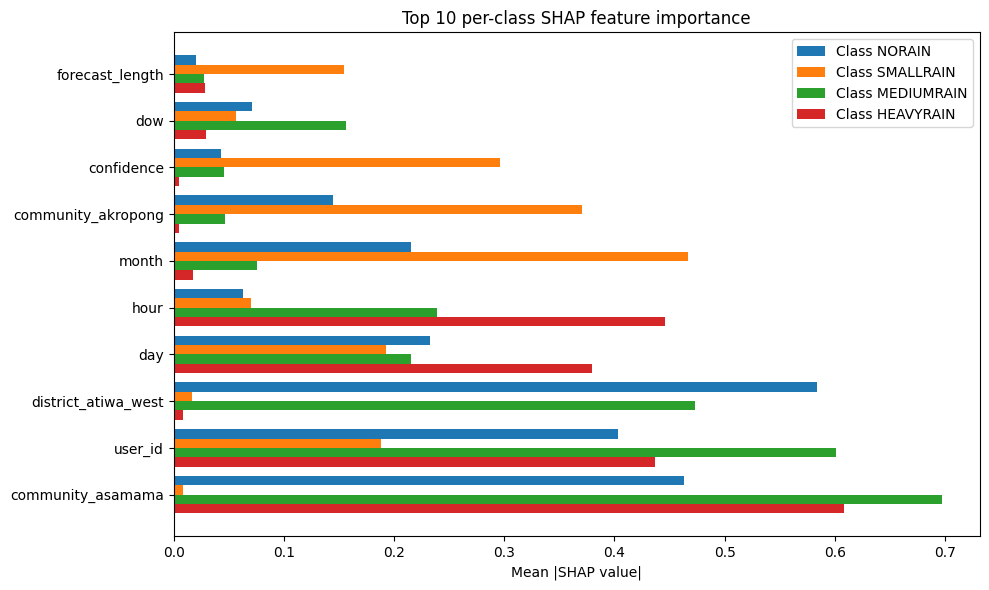

CPU times: user 11min 44s, sys: 167 ms, total: 11min 44s
Wall time: 5min 54s


In [17]:
%%time 

# Use the last trained model or an ensemble
explainer = shap.TreeExplainer(models[-1][0])   # take the last fold model
tree_limit = getattr(models[-1][0], "best_iteration", None)

# SHAP values from explainer
shap_values = explainer.shap_values(train,
                                    check_additivity=False,
                                    tree_limit=tree_limit)

if isinstance(shap_values, list):
    n_classes = len(shap_values)
    class_names = ["NORAIN", "SMALLRAIN", "MEDIUMRAIN", "HEAVYRAIN"]
    
    # Per-class mean |SHAP|
    mean_abs_shap = [np.abs(sv).mean(axis=0) for sv in shap_values]
    
    # Rank features by overall importance (average across classes)
    overall_importance = np.mean(mean_abs_shap, axis=0)
    top_idx = np.argsort(overall_importance)[-10:]  # top 10
    top_features = orig_columns[top_idx]
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ind = np.arange(len(top_idx))  # only top features
    width = 0.8 / n_classes
    
    for i, class_name in enumerate(class_names):
        ax.barh(
            ind + i * width,
            mean_abs_shap[i][top_idx],
            height=width,
            label=f"Class {class_name}"
        )
    
    ax.set_yticks(ind + width * (n_classes - 1) / 2)
    ax.set_yticklabels(top_features)
    ax.invert_yaxis()
    ax.set_xlabel("Mean |SHAP value|")
    ax.set_title("Top 10 per-class SHAP feature importance")
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Binary classification detected — use regular shap.summary_plot instead.")

In [18]:
if isinstance(shap_values, list):  
    # Take mean absolute SHAP values across classes
    shap_values_mean = np.mean([np.abs(sv) for sv in shap_values], axis=0)
else:  
    # Binary classification → shap_values is already an array
    shap_values_mean = shap_values

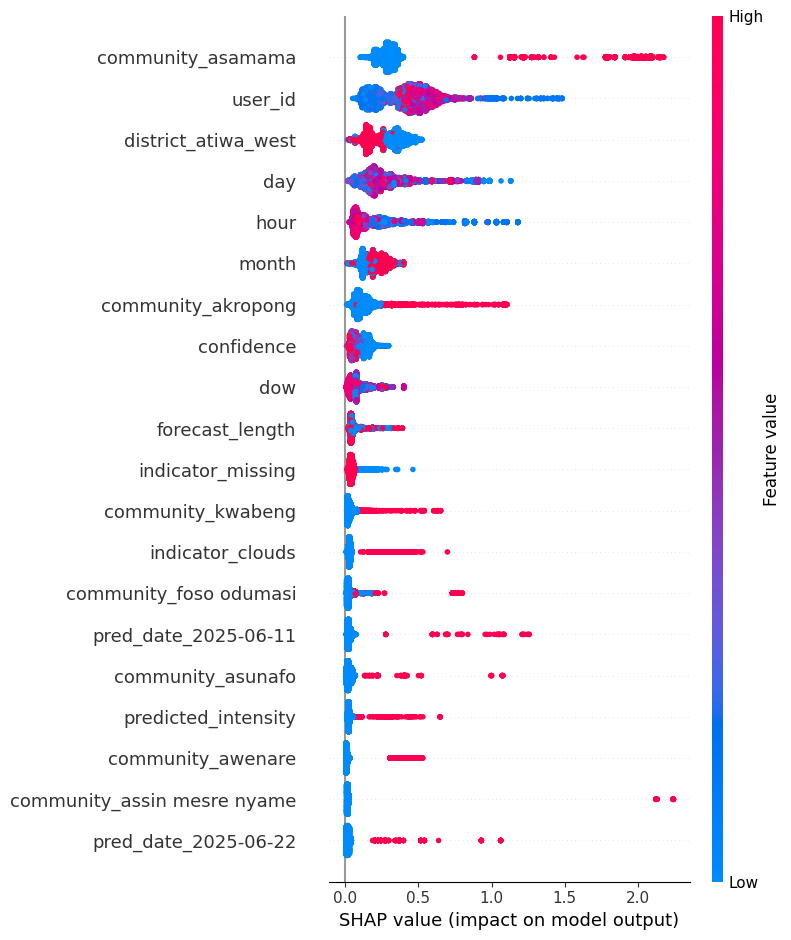

In [19]:
shap.summary_plot(shap_values_mean, train, feature_names=orig_columns, max_display=20)

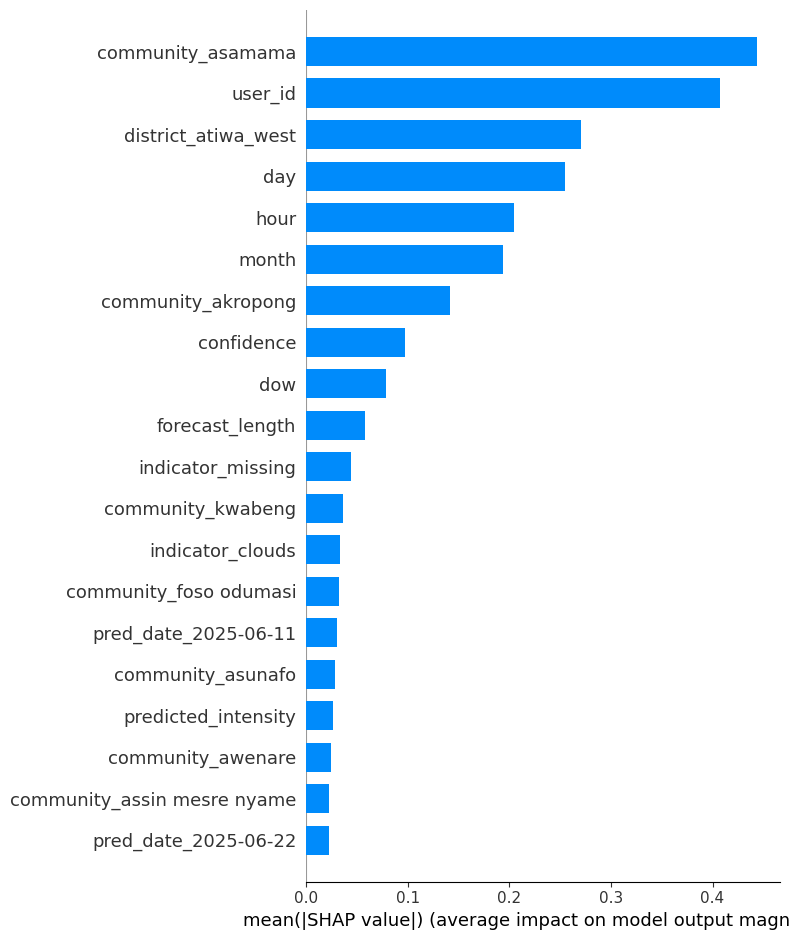

In [20]:
# Summary plot (mean |SHAP| values per feature)
shap.summary_plot(shap_values_mean, train, feature_names=orig_columns, plot_type="bar", max_display=20)

=== SHAP values for class NORAIN ===


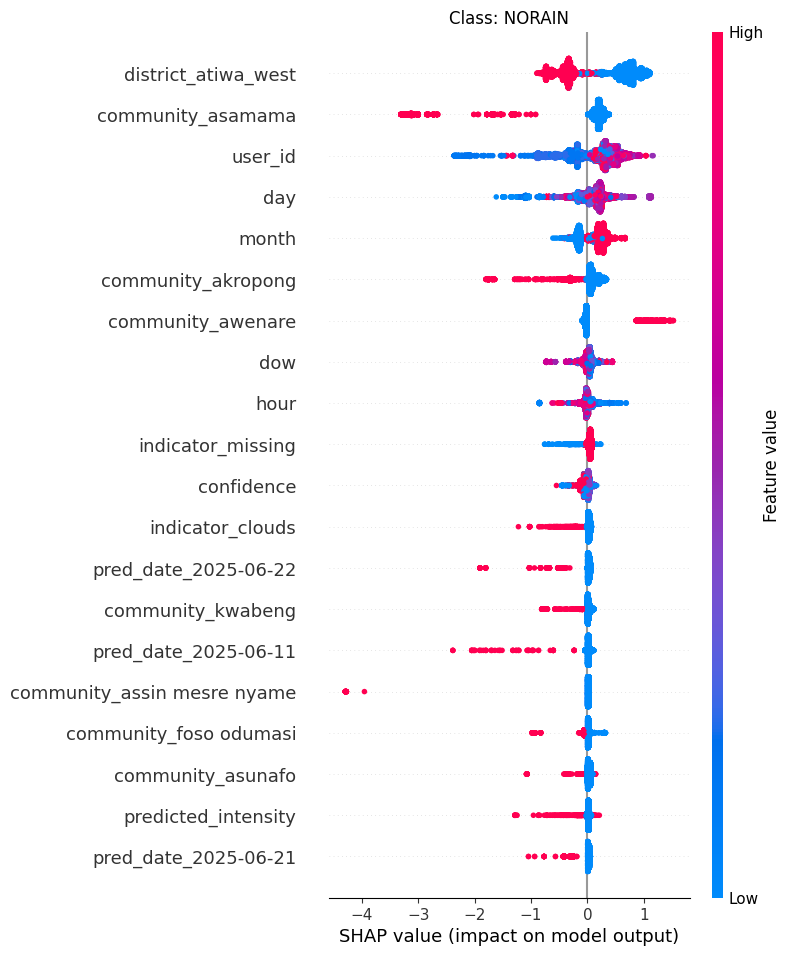

=== SHAP values for class SMALLRAIN ===


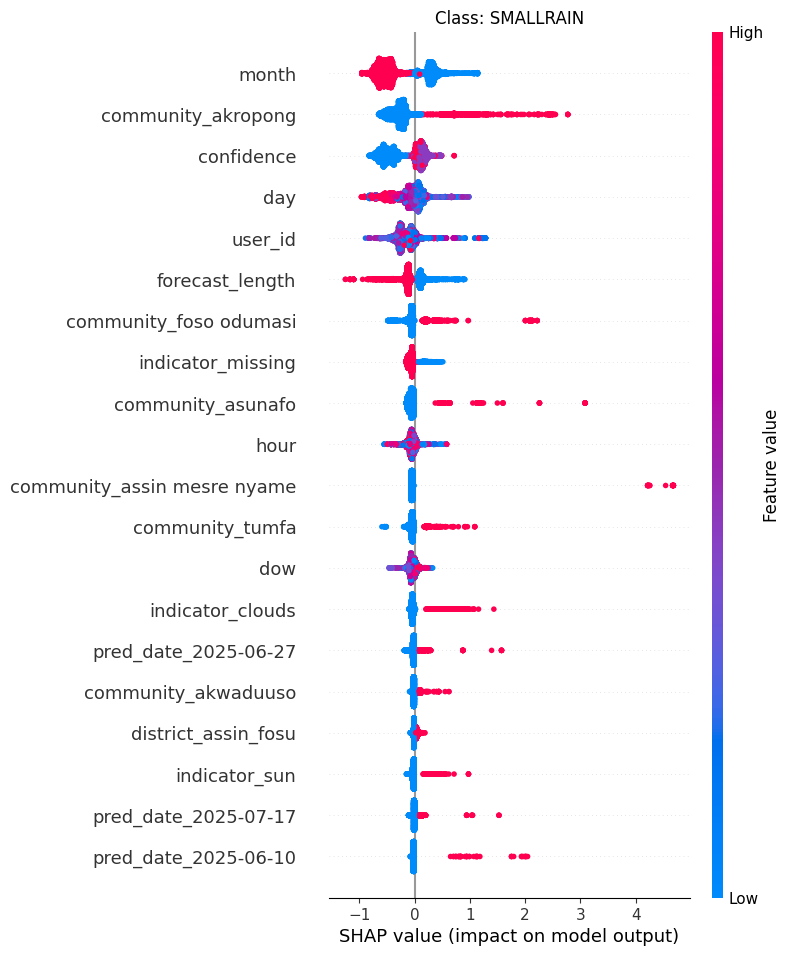

=== SHAP values for class MEDIUMRAIN ===


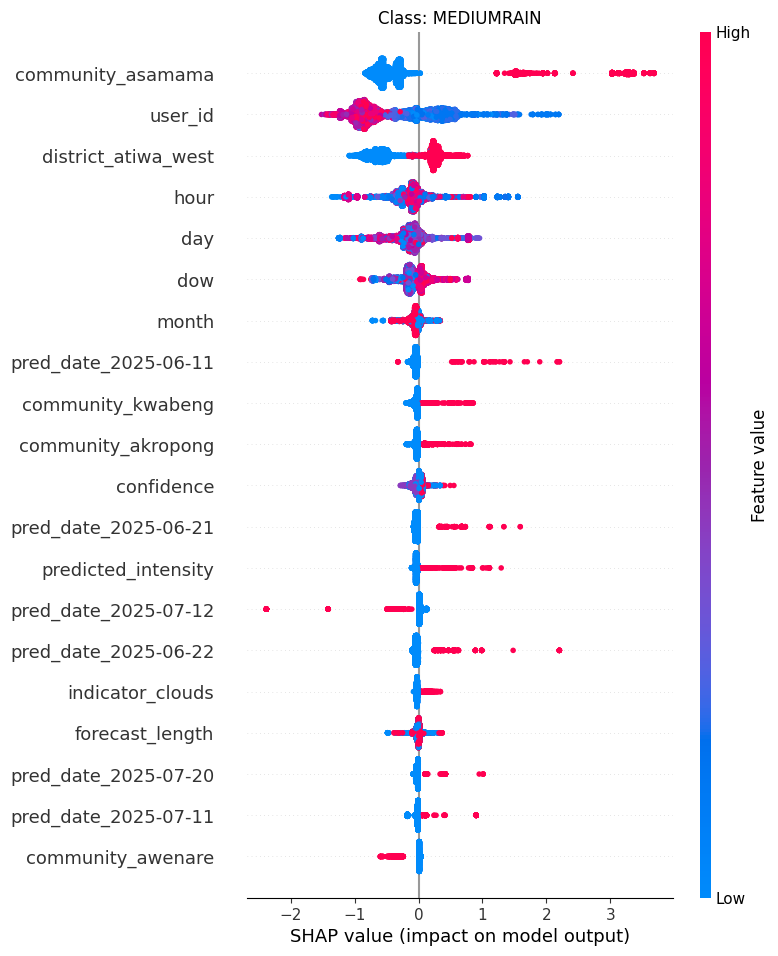

=== SHAP values for class HEAVYRAIN ===


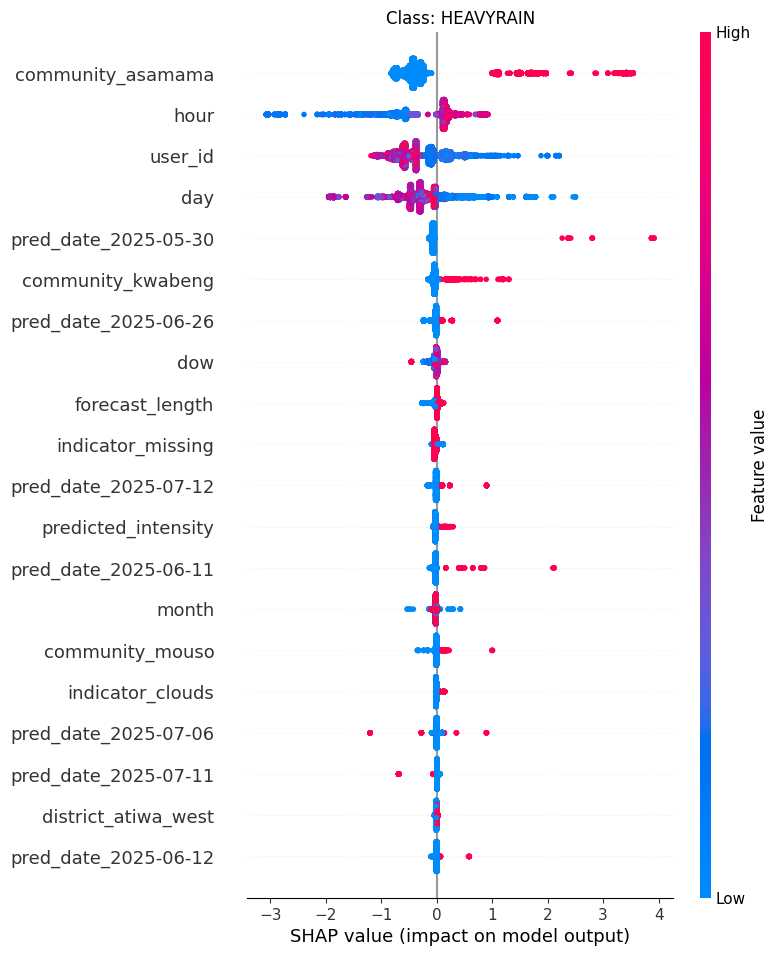

In [21]:
for class_idx, class_name in enumerate(["NORAIN", "SMALLRAIN", "MEDIUMRAIN", "HEAVYRAIN"]):
    print(f"=== SHAP values for class {class_name} ===")
    shap.summary_plot(shap_values[class_idx], train, feature_names=orig_columns, max_display=20, show=False)
    plt.title(f"Class: {class_name}")
    plt.show()

---

## 6. ONNX Models

In this section, we demonstrate how to use the **ONNX-converted models** for inference and verify that their predictions are **identical** to those produced by the original XGBoost models.

### **Overview**

After training, each XGBoost model from the cross-validation folds is converted to **ONNX format** for efficient deployment.
The ONNX models are platform-independent, lightweight, and optimized for faster inference — making them suitable for production environments or systems without Python dependencies.

### **Verification Process**

To ensure reliability, we compare the predictions generated by:

1. The **original XGBoost models**, and
2. The **ONNX runtime session outputs**.

If both models produce the same probability distributions (within an acceptable tolerance), it confirms that the ONNX export process preserved the model’s behavior accurately.

---

In [24]:
%%time

# ------------------------------------------------------------
# Export trained model to ONNX format
# ------------------------------------------------------------
for i, (model, data_shape) in enumerate(models):
    best_iter = model.best_iteration # Number of trees used
    booster = model.get_booster() # Get the individual trees
    booster.limit = best_iter # Trim to only trees used
    
    
    initial_type = [("input", FloatTensorType([None, data_shape]))]
    onnx_model = onnxmltools.convert_xgboost(booster, initial_types=initial_type)
    onnx_path = os.path.join(save_dir, f"xgb_fold_{i+1}.onnx")
    onnx.save_model(onnx_model, onnx_path)

CPU times: user 4min 27s, sys: 7.09 s, total: 4min 34s
Wall time: 3min 36s


In [25]:
# Get paths to all ONNX models in the save directory
onnx_paths = glob.glob("/kaggle/working/onnx_models/*.onnx")

# Initialize an ONNX Runtime InferenceSession for each model
# - providers=["CPUExecutionProvider"] ensures the model runs on CPU
sessions = [rt.InferenceSession(path, providers=["CPUExecutionProvider"]) for path in onnx_paths]

In [26]:
def ensemble_predict(X: np.ndarray) -> np.ndarray:
    """
    Generate ensemble predictions using multiple ONNX models.

    Parameters
    ----------
    X : np.ndarray
        Input feature matrix (samples x features) in float16 format.

    Returns
    -------
    np.ndarray
        Averaged predictions across all models (samples x num_classes).
    """
    preds = []
    for sess in sessions:
        # Get input/output names for the ONNX session
        input_name = sess.get_inputs()[0].name
        output_name = sess.get_outputs()[1].name # This index ensures we're using probabilities

        # Run inference
        pred = sess.run([output_name], {input_name: X.astype(np.float32)})[0]
        preds.append(pred)

    # Average predictions across all models
    return np.mean(preds, axis=0) 

In [27]:
%%time
# Get averaged probabilities
y_pred_proba = ensemble_predict(test.values)

# Convert probability predictions to class labels
# - `y_pred_proba` is from onnx models
# - `pred` → aggregated predictions for the test set
pred_labels = np.argmax(pred, axis=1)
pred_labels_onnx = np.argmax(y_pred_proba, axis=1)

CPU times: user 14.8 s, sys: 6 ms, total: 14.8 s
Wall time: 6.7 s


In [28]:
# Compare predicted class labels from both sources
# - pred_labels: from original XGBoost models
# - pred_labels_onnx: from ONNX ensemble inference
consistent = np.allclose(pred_labels, pred_labels_onnx, atol=1e-5)

print("Are ONNX predictions consistent with XGBoost outputs? ", consistent)

Are ONNX predictions consistent with XGBoost outputs?  True


---

## 7. Submission File

After completing model training, validation, and SHAP-based interpretation, the final step involves preparing a **submission file** for the Zindi competition platform. This submission contains the model’s predicted rainfall categories for each test instance.

### Process Overview

The submission process follows these key steps:

1. **Model Averaging**

   * Predictions from all 20 trained XGBoost folds (i.e onnx models used) are averaged to reduce variance and improve robustness.
   * Each fold contributes equally to the final predicted probabilities.

2. **Class Selection**

   * For every test sample, the class (rainfall category) with the **highest mean predicted probability** is selected as the final prediction.
   * The four possible classes are:

     * `No Rain`
     * `Small Rain`
     * `Medium Rain`
     * `Heavy Rain`

---

In [29]:
SUBMISSION_PATH ="/kaggle/input/ghanas-indigenous-challenge-dataset/SampleSubmission.csv"
submission = pd.read_csv(SUBMISSION_PATH)
submission["ID"] = test_id
submission["Target"] = pred_labels_onnx
submission["Target"] = submission["Target"].map({
    0: "NORAIN",
    1: "SMALLRAIN",
    2: "MEDIUMRAIN",
    3: "HEAVYRAIN"
})
submission.to_csv("final_submission.csv", index=False)

---

## 8. Conclusion and Final Remarks

### **Conclusion**

This project successfully developed a robust **Rainfall Prediction Model** using **Indigenous Ecological Indicators (IEIs)** to forecast rainfall intensity into four classes — *No Rain, Small Rain, Medium Rain, and Heavy Rain.*

Through systematic **ETL**, **feature engineering**, and **modeling** using **20-fold stratified cross-validation**, the solution achieved **high accuracy and stability** across folds.
The integration of **One-Hot Encoding** for categorical variables enhanced interpretability, while **XGBoost** provided the flexibility and performance required for multi-class classification tasks.

Model interpretability was strengthened using **SHAP values**, enabling clear visibility into the feature contributions behind predictions.
Key influencing features such as *community*, *indicator*, and *temporal patterns* provided meaningful insights consistent with the indigenous ecological context.

Overall, the model demonstrated:

* Excellent generalization performance (Private F1-Macro: **0.9715**).
* Reliable consistency across all 20 folds.
* Transparent and reproducible workflow.

These results indicate that **traditional ecological indicators**, when combined with **modern machine learning techniques**, can provide strong predictive capabilities for environmental forecasting.


### **Final Remarks**

This project demonstrates the **synergy between indigenous knowledge systems and modern AI methodologies**, highlighting how data-driven models can support **climate resilience** and **sustainable development** efforts in local communities.

With further refinement, this approach can be scaled to broader regional and continental applications, contributing meaningfully to **AI for climate adaptation** and **environmental sustainability**.

---